## CA 2, LLMs Spring 2024

- **Name:** Majid Faridfar
- **Student ID:** 810199569

---

## Section 1: Generate a Single Sentence (20 points)
Write a prompt that has ten tokens according to the GPT-2 tokenizer. (2 points)

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import time
model_name = "gpt2"

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
# prompt = "Write a prompt that has ten tokens according to gpt2 tokenizer "
# ## print the tokens, input_ids, and attention_mask

prompt = "A lost civilization deep in a jungle was found which"

tokens = tokenizer(prompt, return_tensors="pt")

print("Prompt:", prompt)
print("Number of tokens:", len(tokenizer.tokenize(prompt)))
print("Tokens:", tokenizer.tokenize(prompt))
print("Input IDs:", tokens["input_ids"])
print("Attention Mask:", tokens["attention_mask"])

Prompt: A lost civilization deep in a jungle was found which
Number of tokens: 10
Tokens: ['A', 'Ġlost', 'Ġcivilization', 'Ġdeep', 'Ġin', 'Ġa', 'Ġjungle', 'Ġwas', 'Ġfound', 'Ġwhich']
Input IDs: tensor([[   32,  2626, 14355,  2769,   287,   257, 20712,   373,  1043,   543]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


### a) Load the model to the GPU
Use the prompt you wrote and generate 190 new tokens, appending each new token to the previous sequence at each step. Measure the time of generating each new token. You CAN ONLY use PyTorch for decoding; use greedy decoding. You will get a 200-token sequence at the end, so print the sentence.

Plot the time needed for generating each new token. Use torch.cuda.max_memory_allocated and plot the memory used at each step in MB. At each step, by giving the input_ids to the model as the labels argument, the loss will be calculated for you automatically. Plot the loss at all steps.
(compute loss only for this part of the assignment)

Explain the patterns you see in the plots. (8 points)

In [4]:
a_times = []
a_losses = []
a_memories = []

torch.cuda.empty_cache()

a_model = model.to("cuda")
a_tokens = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    for _ in range(190):
        torch.cuda.reset_peak_memory_stats()

        start_time = time.time()
        outputs = a_model(**a_tokens, labels=a_tokens["input_ids"])
        end_time = time.time()

        a_times.append(end_time-start_time)
        a_losses.append(outputs.loss.item())
        a_memories.append(torch.cuda.max_memory_allocated() / 1024 / 1024)  # Convert to MB

        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1)

        a_tokens["input_ids"] = torch.cat([a_tokens["input_ids"], next_token_id.unsqueeze(-1)], dim=-1)
        a_tokens["attention_mask"] = torch.cat([a_tokens["attention_mask"], torch.ones((1, 1), device="cuda")], dim=-1)

a_generated_sequence = tokenizer.decode(a_tokens["input_ids"].squeeze().tolist())
print(a_generated_sequence)

A lost civilization deep in a jungle was found which had been abandoned by the inhabitants. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown.

The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown.

The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown.

The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the los

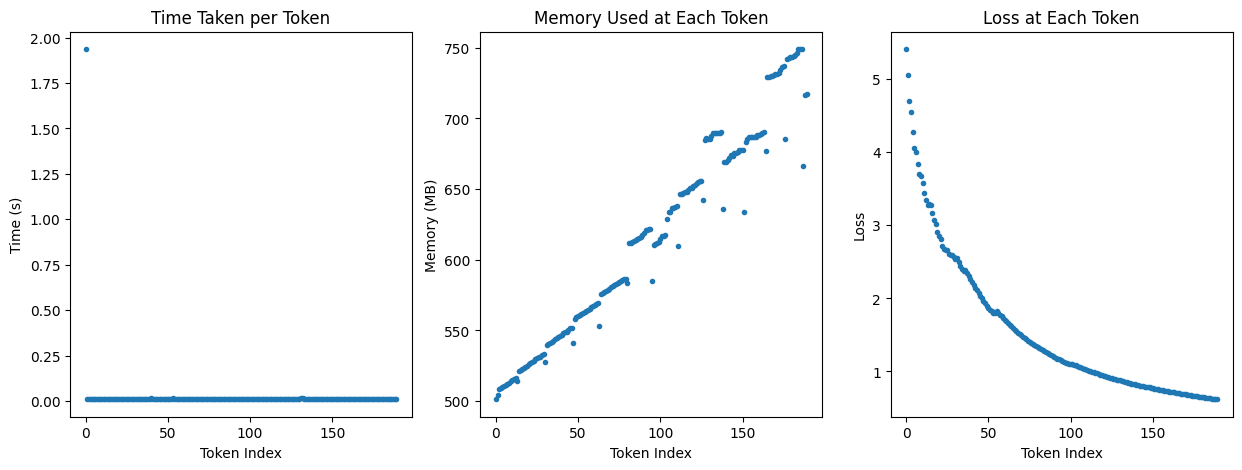

In [5]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 3, 1)
plt.plot(a_times, marker=".", linestyle='', label="Time per Token")
plt.xlabel("Token Index")
plt.ylabel("Time (s)")
plt.title("Time Taken per Token")

ax = plt.subplot(1, 3, 2)
plt.plot(a_memories, marker=".", linestyle='', label="Memory Used")
plt.xlabel("Token Index")
plt.ylabel("Memory (MB)")
plt.title("Memory Used at Each Token")

ax = plt.subplot(1, 3, 3)
plt.plot(a_losses, marker=".", linestyle='', label="Loss")
plt.xlabel("Token Index")
plt.ylabel("Loss")
plt.title("Loss at Each Token")

plt.show()

**Analysis**:

> - **Time**: It takes a few and almost constant time to generate each new token. That is because the model structure is fixed, and each token is processed independently, paralelly, and in the same way.
> - **Memory**: The memory space used by model increases after generating every token by an almost linear rate with the number of generated tokens. That is because when the sequence becomes longer and longer, model should store more information for every token, or in other words, the given+generated context, to process, iterate on and generate the next token.
> - **Loss**: The more tokens model generates the fewer loss it causes. That is because of the training phase of the model. Model has learned to minimize its loss for generating the next token when it is received more input tokens and a longer context to decide and consider.

### b) Use past_key_values
Give the past_key_values to the model during generation, and repeat all of the above steps; then, compare the results. (10 points)

In [6]:
b_times = []
# b_losses = []
b_memories = []
b_throughputs = []

torch.cuda.empty_cache()

b_model = model.to("cuda")
b_tokens = tokenizer(prompt, return_tensors="pt").to("cuda")

past_key_values = None
all_tokens = b_tokens["input_ids"]

with torch.no_grad():
    for _ in range(190):
        torch.cuda.reset_peak_memory_stats()

        start_time = time.time()
        outputs = b_model(**b_tokens, past_key_values=past_key_values)
        end_time = time.time()

        b_times.append(end_time-start_time)
        # losses.append(outputs.loss.item())
        b_memories.append(torch.cuda.max_memory_allocated() / 1024 / 1024)  # Convert to MB
        b_throughputs.append(1 / (end_time - start_time))

        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1)

        # b_tokens["input_ids"] = torch.cat([b_tokens["input_ids"], next_token_id.unsqueeze(-1)], dim=-1)
        b_tokens["input_ids"] = next_token_id.unsqueeze(-1)
        # b_tokens["attention_mask"] = torch.cat([b_tokens["attention_mask"], torch.ones((1, 1), device="cuda")], dim=-1)
        b_tokens["attention_mask"] = torch.ones((1, 1), device="cuda")

        past_key_values = outputs.past_key_values
        all_tokens = torch.cat([all_tokens, next_token_id.unsqueeze(-1)], dim=-1)

b_generated_sequence = tokenizer.decode(all_tokens.squeeze().tolist())
print(b_generated_sequence)

A lost civilization deep in a jungle was found which had been abandoned by the inhabitants. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown.

The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown.

The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown.

The inhabitants of the jungle were not aware of the existence of the lost civilization and were afraid of the unknown. The inhabitants of the jungle were not aware of the existence of the los

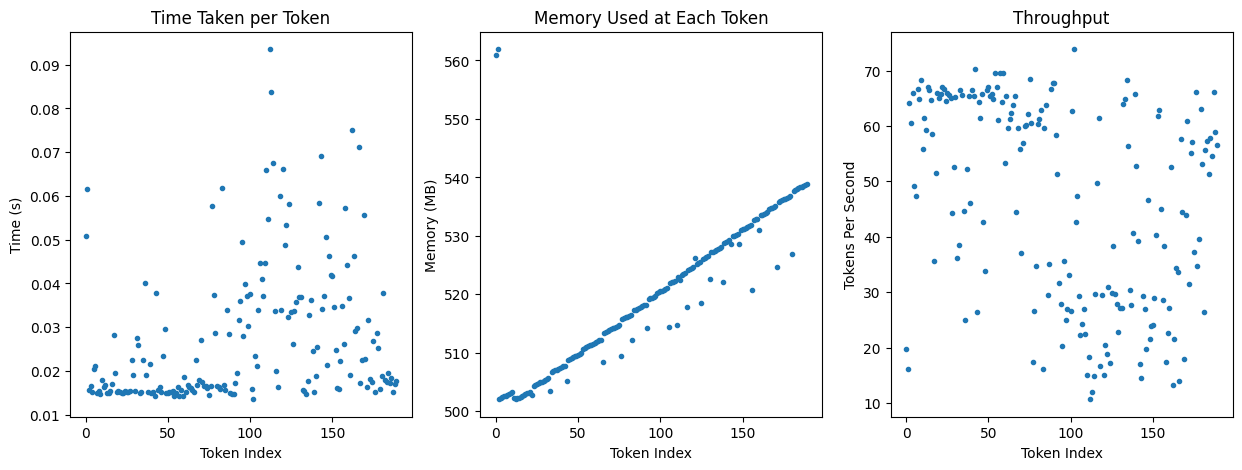

In [7]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 3, 1)
plt.plot(b_times, marker=".", linestyle='', label="Time per Token")
plt.xlabel("Token Index")
plt.ylabel("Time (s)")
plt.title("Time Taken per Token")

ax = plt.subplot(1, 3, 2)
plt.plot(b_memories, marker=".", linestyle='', label="Memory Used")
plt.xlabel("Token Index")
plt.ylabel("Memory (MB)")
plt.title("Memory Used at Each Token")

ax = plt.subplot(1, 3, 3)
plt.plot(b_throughputs, marker=".", linestyle='', label="Memory Used")
plt.xlabel("Token Index")
plt.ylabel("Tokens Per Second")
plt.title("Throughput")

# ax = plt.subplot(1, 3, 3)
# plt.plot(losses, marker=".", linestyle='', label="Loss")
# plt.xlabel("Token Index")
# plt.ylabel("Loss")

plt.show()

**Analysis**:

> As you can see, the plots show the same things as previous part of the notebook (Section 1, Part a): A few and almost constant time is needed to generate the next token, and memory usage increases by generating more tokens by a linear rate with number of already generated tokens.

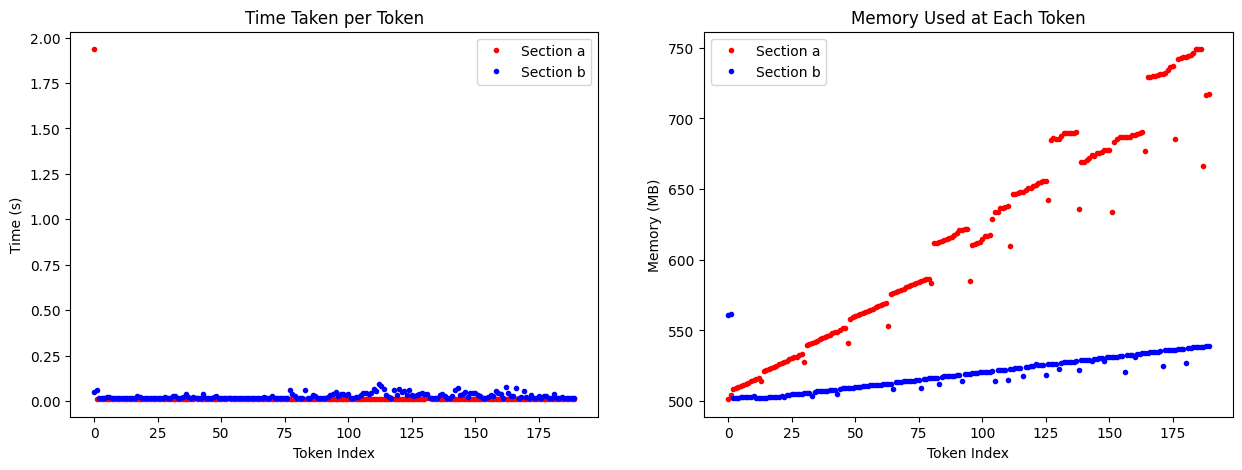

In [14]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(a_times, marker=".", linestyle='', color="red", label="Section a")
ax.plot(b_times, marker=".", linestyle='', color="blue", label="Section b")
ax.set_xlabel("Token Index")
ax.set_ylabel("Time (s)")
plt.title("Time Taken per Token")
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(a_memories, marker=".", linestyle='', color="red", label="Section a")
ax.plot(b_memories, marker=".", linestyle='', color="blue", label="Section b")
ax.set_xlabel("Token Index")
ax.set_ylabel("Memory (MB)")
plt.title("Memory Used at Each Token")
ax.legend()

plt.show()

**Analysis**:

> - **Time**: Generating new tokens takes relatively equl, constant and few time in both cases (Section 1, part a and b). That is because the latency in both cases is the same.
> - **Memory**: As we have used `past_key_values` in the second part, we can see the memory usage has considerably reduced about 200 MBs. That is because in this way model caches some previously done calcultions and avoids repeating a lot of computations for generating next token.

## Section 2: Batch Generation (25 points)
Write 4 prompts (a list of 4 sentences). All the sentences you write should have different lengths. Print the input_ids and attention_mask, and explain why the attention_masks are the way they are. When you tokenize, use left-side padding. Explain why left-side padding is preferable during inference. What is the padding token ID in this particular tokenizer?
(10 points)

In [9]:
prompts = [
    "Napeleon was the leader of ",
    "Describe the role of the Silk Road in facilitating cultural exchange between East and West during ancient times.",
    "What were the underlying causes and tensions that led to the outbreak of World War II?",
    "Who were the pilots carrying out the 9/11 terrorist attacks?"
]

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenized_prompts = tokenizer(prompts, padding=True, return_tensors='pt')

for i in range(len(prompts)):
    print("Prompt:", prompts[i])
    print("Number of Tokens:", len(tokenizer.tokenize(prompts[i])))
    print("Input IDs:", tokenized_prompts.input_ids[i])
    print("Attention Mask:", tokenized_prompts.attention_mask[i])
    print("***************************************\n")

Prompt: Napeleon was the leader of 
Number of Tokens: 8
Input IDs: tensor([50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256,    45,  1758, 38970,   373,   262,  3554,   286,   220])
Attention Mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
***************************************

Prompt: Describe the role of the Silk Road in facilitating cultural exchange between East and West during ancient times.
Number of Tokens: 20
Input IDs: tensor([24564,  4892,   262,  2597,   286,   262, 26006,  5567,   287, 36045,
         6467,  5163,  1022,  3687,   290,  2688,  1141,  6156,  1661,    13])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
***************************************

Prompt: What were the underlying causes and tensions that led to the outbreak of World War II?
Number of Tokens: 17
Input IDs: tensor([50256, 50256, 50256,  2061,   547,   262, 10238,  5640,   290, 15733,
         

Explain why the attention_masks are the way they are.

> - *The second prompt (**Describe the role of the Silk Road in facilitating cultural exchange between East and West during ancient times.**)*: This prompt is already of maximum length, so no padding is required. All tokens are marked with 1 in the `attention_mask`, indicating that they should be attended to during computation.
> - *Other prompts*: Since they is shorter than the maximum length allowed, padding tokens are added to match the length of the longest prompt in the batch. The `attention_mask` marks these padding tokens with 0, indicating that they should be ignored during computation, and the focus of model should be on more important parts.

Explain why left-side padding is preferable during inference.

> 1. The context before the current token is often more relevant for generating the next token. By padding on the left side, the original sequence's right-most tokens, which contain the most recent context, remain unchanged. In this way, model has access to the most recent information when making predictions.
> 2. During training, models are trained with left-side padding. Therefore, using left-side padding during inference results in consistency between the training and inference phases.
> 3. For predictinf the next token of a <|pad|> token, LTR padding causes placing context in the right side.

What is the padding token ID in this particular tokenizer?

> In this particular tokenizer, the padding token is end-of-sequence (`[EOS]`). Because I set `tokenizer.pad_token = tokenizer.eos_token`. So its ID is 50256.
> Additionally, in many tokenizers and libraries, the special token `[PAD]` is often used as the padding token. Its ID is 50258.

For batch decoding, you should also give position_ids to the model. You should create the position_ids yourself. Explain what position_ids are and how they help. Print the position_ids of your batch prompt. Repeat Section 1, Subsection b, but this time, use the prompt in batch form and give position_ids to the model. Plot the memory needed at each step. Plot the time needed at each step, also plot number of tokens generated per second (a.k.a. throughput). Compare the throughput and memory usage of batch generation with single sentence generation. (15 points)

In [10]:
c_times = []
# b_losses = []
c_memories = []
c_throughputs = []

torch.cuda.empty_cache()

c_model = model.to("cuda")
c_model.config.pad_token_id = tokenizer.pad_token_id

c_tokens = tokenizer(prompts, padding=True, return_tensors='pt').to("cuda")

batch_size, max_length = tokenized_prompts.input_ids.shape
position_ids = torch.arange(max_length).unsqueeze(0).to("cuda")

print("Position IDs:")
print(position_ids)
print("***************************\n")

past_key_values = None
all_tokens = c_tokens["input_ids"]

with torch.no_grad():
    for _ in range(190):
        torch.cuda.reset_peak_memory_stats()

        start_time = time.time()
        outputs = model(**c_tokens, position_ids=position_ids, past_key_values=past_key_values)
        end_time = time.time()

        c_times.append(end_time-start_time)
        # losses.append(outputs.loss.item())
        c_memories.append(torch.cuda.max_memory_allocated() / 1024 / 1024)  # Convert to MB
        c_throughputs.append(batch_size / (end_time - start_time))

        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1)

        # c_tokens["input_ids"] = torch.cat([c_tokens["input_ids"], next_token_id.unsqueeze(-1)], dim=-1)
        c_tokens["input_ids"] = next_token_id.unsqueeze(-1)
        # c_tokens["attention_mask"] = torch.cat([c_tokens["attention_mask"], torch.ones((1, 1), device="cuda")], dim=-1)
        # c_tokens["attention_mask"] = torch.ones((1, 1), device="cuda")
        c_tokens["attention_mask"] = torch.ones((batch_size, 1), device="cuda")

        past_key_values = outputs.past_key_values
        all_tokens = torch.cat([all_tokens, next_token_id.unsqueeze(-1)], dim=-1)

        position_ids = torch.tensor([position_ids[:, -1:] + 1]).unsqueeze(0).to("cuda")

c_generated_sentences = {}
for i in range(len(prompts)):
    c_generated_sentences[prompts[i]] = tokenizer.decode(all_tokens[i].squeeze().tolist())
    print("Prompt:", prompts[i])
    print("Response:", c_generated_sentences[prompts[i]])
    print("***************************\n")

Position IDs:
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]], device='cuda:0')
***************************

Prompt: Napeleon was the leader of 
Response: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Napeleon was the leader of  the world's "The Story of the world's a
"I'm a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman who is a woman wh

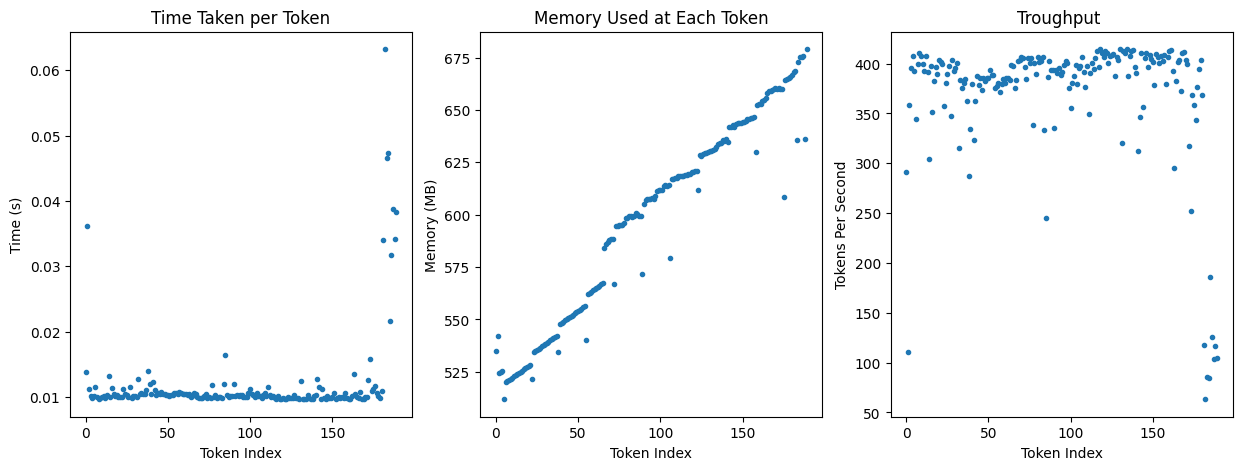

In [11]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 3, 1)
plt.plot(c_times, marker=".", linestyle='', label="Time per Token")
plt.xlabel("Token Index")
plt.ylabel("Time (s)")
plt.title("Time Taken per Token")

ax = plt.subplot(1, 3, 2)
plt.plot(c_memories, marker=".", linestyle='', label="Memory Used")
plt.xlabel("Token Index")
plt.ylabel("Memory (MB)")
plt.title("Memory Used at Each Token")

ax = plt.subplot(1, 3, 3)
plt.plot(c_throughputs, marker=".", linestyle='', label="Memory Used")
plt.xlabel("Token Index")
plt.ylabel("Tokens Per Second")
plt.title("Troughput ")

# ax = plt.subplot(1, 3, 3)
# plt.plot(losses, marker=".", linestyle='', label="Loss")
# plt.xlabel("Token Index")
# plt.ylabel("Loss")

plt.show()

Explain what position_ids are and how they help.

> `position_ids` are used to encode the position of tokens within a sequence. As transformer-based models ike GPT, unlike RNNs, cannot understand the order of the tokens in a sequence and process tokens in parallel, additional positional information is required to understand the sequential order. Positional encoding usually involves adding fixed-length vectors (here, <0, 1, 2,...>) to the embeddings of tokens to represent their positions in the sequence and are possibly learned during the training process (not in all cases).

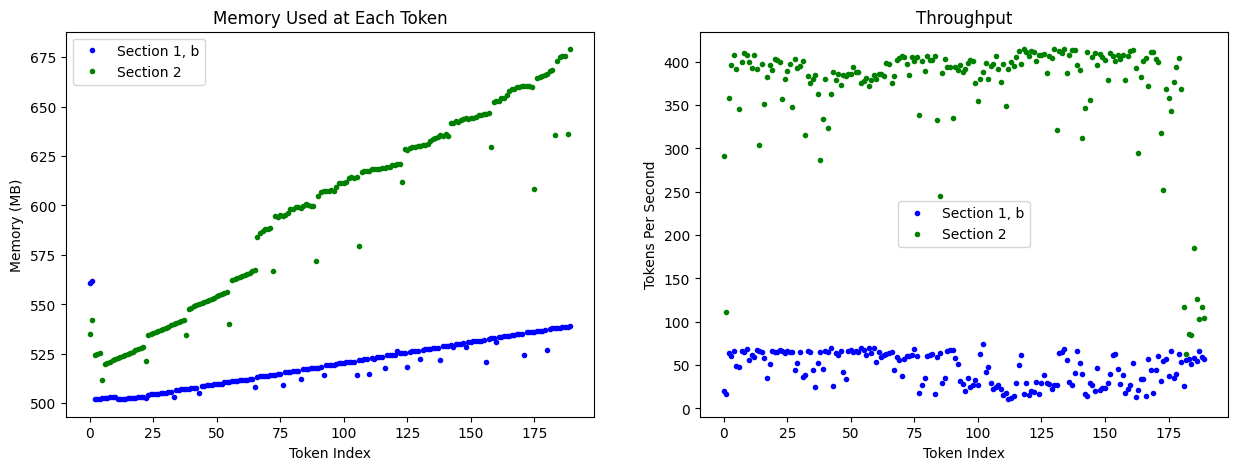

In [15]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(b_memories, marker=".", linestyle='', color="blue", label="Section 1, b")
ax.plot(c_memories, marker=".", linestyle='', color="green", label="Section 2")
ax.set_xlabel("Token Index")
ax.set_ylabel("Memory (MB)")
plt.title("Memory Used at Each Token")
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(b_throughputs, marker=".", linestyle='', color="blue", label="Section 1, b")
ax.plot(c_throughputs, marker=".", linestyle='', color="green", label="Section 2")
ax.set_xlabel("Token Index")
ax.set_ylabel("Tokens Per Second")
plt.title("Throughput")
ax.legend()

plt.show()

**Analysis**:

> - **Memory**: Batch generation requires more space on memory, as it generates multiple sequences.
> - **Throughput**: As you can see, by batch generation, we have achieved a higher throughput which means more tokens are generated per second.